In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Determining ratings from number of listens

https://towardsdatascience.com/what-is-group-normalization-45fe27307be7

### Original data
This data is extremely left skewed, look at the 75% compared to the max

In [2]:
scrobsdf = pd.read_csv("./data/lastfm_user_scrobbles.csv")
scrobsdf.scrobbles.describe()

count     92792.000000
mean        745.521521
std        3752.146187
min           1.000000
25%         107.000000
50%         260.000000
75%         614.000000
max      352698.000000
Name: scrobbles, dtype: float64

Reading into a sparse matrix

In [3]:
scrobsM = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobsM[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["scrobbles"]
scrobsM = scrobsM.tocsr()

### Comparing users

Here we can see that the listening habits of distinct users are on wildly different scales

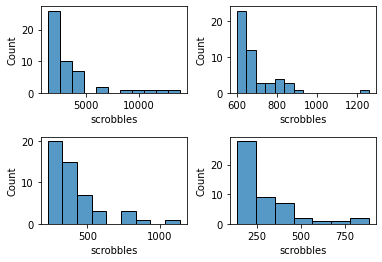

In [4]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.5, wspace=0.3)
ax = fig.add_subplot(2,2,1)
ax.set_xlabel("scrobbles")
sns.histplot(scrobsM[1].data,ax=ax)
for i in range(2,5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_xlabel("scrobbles")
    sns.histplot(scrobsM[i+11].data, ax=ax)

plt.show()

### User Normalization

To make users comparable, we can normalize by each user's maximum and mean

In [8]:
umean = scrobsdf.groupby("user_id").scrobbles.transform('mean').to_numpy()
scrobsdf["std"] = scrobsdf.scrobbles - umean

ustd = scrobsdf.groupby("user_id")["std"]
ustdmin = ustd.transform('min').to_numpy()
ustdmax = ustd.transform('max').to_numpy()
# stdsum = uscrobs.transform('sum').to_numpy()

In [9]:
scrobsdf["rating"] = (scrobsdf["std"] - ustdmin) / (ustdmax-ustdmin)

Drop users who havent' listened to a range of artists

In [ ]:
# badusers = scrobsdf.iloc[(smax-smin) == 0].user_id.unique()
# scrobsdf = scrobsdf[~scrobsdf.user_id.isin(badusers)]

# uscrobs = scrobsdf.groupby("user_id").scrobbles
# smin = uscrobs.transform('min').to_numpy()
# smax = uscrobs.transform('max').to_numpy()
# ssum = uscrobs.transform('sum').to_numpy()
# smean = uscrobs.transform('mean').to_numpy()
# smin = smean - smin
# smax = smax - smean

In [ ]:
# scrobsdf["rating"] = (abs(smean - scrobsdf.scrobbles) - smin) / (smax-smin)

In [ ]:
# scrobsdf.scrobbles[(abs(smean - scrobsdf.scrobbles) - smin) <= 0]

In [11]:
scrobsM = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobsM[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["rating"]
scrobsM = scrobsM.tocsr()

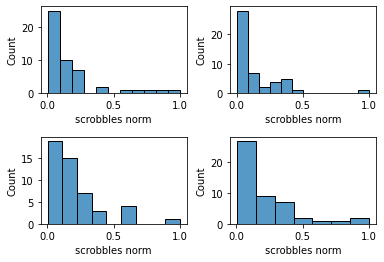

In [12]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.5, wspace=0.3)
ax = fig.add_subplot(2,2,1)
ax.set_xlabel("scrobbles norm")
sns.histplot(scrobsM[1].data,ax=ax)
for i in range(2,5):
    ax = fig.add_subplot(2, 2, i)
    ax.set_xlabel("scrobbles norm")
    sns.histplot(scrobsM[i+11].data, ax=ax)

plt.show()

This is much better, each user is on the same scale. We put min and max in terms of the mean (representing standard deviation) as otherwise the overall data contained an abundance of 0 unit and 1 unit ratings, as the user's top artist always received a score of 1 and last artist a score of 0.

However, the overall data is still very skewed, and not representative of an artist's rating:

In [ ]:
sns.displot(scrobsdf.rating)

In [ ]:
df = pd.read_csv("./data/lastfm_user_scrobbles.csv")
artdf = pd.read_csv("./data/lastfm_artist_list.csv")
artdf = artdf.set_index("artist_id")
artists = artdf.to_numpy().flatten()
artists = np.insert(artists,0,'___empty___')
df.scrobbles.describe()

In [ ]:
def unskew(scrobs): 
    denom_max = np.repeat(scrobs.max(axis=1).A, scrobs.getnnz(axis=1))
    denom_min = np.repeat(scrobs.min(axis=1).A, scrobs.getnnz(axis=1)) # incorrect, gives 0, we want non-zero minimum
    return (scrobs.data - denom_min)/(denom_max - denom_min)
# scrobs.data = unskew(scrobs)

In [ ]:
scrobsdf = pd.read_csv("./data/lastfm_user_scrobbles.csv")
df=scrobsdf
df["artist"] = artdf.loc[df["artist_id"].to_numpy()]["artist_name"].to_numpy()
# df["rating"] = (df.scrobbles) / df.groupby("user_id").scrobbles.transform('max').to_numpy()
scrobmin = df.groupby("user_id").scrobbles.transform('min').to_numpy()
scrobmax = df.groupby("user_id").scrobbles.transform('max').to_numpy()
scrobsum = df.groupby("user_id").scrobbles.transform('sum').to_numpy()
scrobsmean = df.groupby("user_id").scrobbles.transform('mean').to_numpy()

df["rating"] = (df.scrobbles) / (scrobmax+scrobsmean)
# df["rating"] = df.scrobbles/scrobsum

In [ ]:
for i in range(10):
    print(0.1**i)
    eps = 0.1**i
    newrating = (np.log(df.rating+eps))# + 12

    newrating += abs(newrating.min())

    newrating = pd.DataFrame(newrating)
    print(newrating.describe())
    sns.displot(newrating)


In [ ]:
scrobs = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobs[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["scrobbles"]
scrobs = scrobs.tocsr()
top50_scrobbled = artists[(scrobs.sum(axis=0)).A[0].argsort()[::-1]][:50]

In [ ]:
ratings = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
ratings[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["rating"]
ratings = ratings.tocsr()
top50_rated = artists[(ratings.sum(axis=0)).A[0].argsort()[::-1]][:50]

In [ ]:
pd.DataFrame(np.array([top50_rated, top50_scrobbled]).T, columns=["rating", "#listens"])

In [ ]:
scrobsdf = pd.read_csv("./data/lastfm_user_scrobbles.csv")
scrobs = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobs[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["scrobbles"]
scrobs = scrobs.tocsr()
# scrobs.sum(axis=1)
scrobs.min(axis=1).A

In [ ]:
scrobsdf = pd.read_csv("./data/lastfm_user_scrobbles.csv")
scrobs = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobs[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["scrobbles"]
scrobs = scrobs.tocsr()

def unskew(scrobs):
#     denom_max = np.repeat(scrobs.sum(axis=1).A, scrobs.getnnz(axis=1))
#     return scrobs.data/denom_max
    
    denom_max = np.repeat(scrobs.max(axis=1).A, scrobs.getnnz(axis=1))
    denom_min = np.repeat(scrobs.min(axis=1).A, scrobs.getnnz(axis=1)) # incorrect, gives 0, we want non-zero minimum
    return (scrobs.data - denom_min)/(denom_max - denom_min)

scrobs.data = unskew(scrobs)
# scrobs.data=np.log(scrobs.data) + 12
# print(pd.DataFrame(scrobs.data).describe())
# sns.displot((scrobs.data))

In [ ]:
pd.DataFrame(scrobs.data).describe()

In [ ]:
scrobs.A

In [ ]:
for i in range(10):
    sns.displot(scrobs[i].data)

### Data reading

In [ ]:
scrobsdf = pd.read_csv("./data/lastfm_user_scrobbles.csv")

In [ ]:
df = scrobsdf
df.scrobbles.describe()

In [ ]:
def normalize(column):
    upper = column.max()
    lower = column.min()
    y = (column - lower)/(upper-lower)
    return y

In [ ]:
gmax = df.groupby("user_id").scrobbles.transform('max')
gmin = df.groupby("user_id").scrobbles.transform('min')
df.scrobbles = (df.scrobbles - gmin)/(gmax-gmin)

In [ ]:
normlog = df.scrobbles#normalize(np.log(df.scrobbles))
print(normlog.describe())
sns.displot(normlog)

In [ ]:
artdf = pd.read_csv("./data/lastfm_artist_list.csv")
artdf = artdf.set_index("artist_id")

In [ ]:
artdf[artdf["artist_name"].str.contains("ollier")]

### Make scipy csr sparse matrix from lil with users as rows and artist as column with # scrobbles as value

In [ ]:
scrobs = sparse.lil_matrix((max(scrobsdf["user_id"])+1, max(scrobsdf["artist_id"])+1)) # 0 indexing
scrobs[scrobsdf["user_id"], scrobsdf["artist_id"]] = scrobsdf["scrobbles"]
scrobs = scrobs.tocsr()

### Change #listens to ratings

This is to make collaborative filtering work, rather than values like 100, 90, 80 for the top 3 artists of a user, these would be scores representing how they might rate those artists. 

1. Divide by max
    * result: 1, .9, .8
    * ranking of a user's artists
    * 
2. Divide by sum
    * result: 0.37, 0.33, 0.29
    * proportion of total listens that artist occupies
    * users with many artists have lower ratings
    * ranking doesn't affect rating, so 

In [ ]:
pd.DataFrame(unskew(scrobs)).describe()

In [ ]:
sns.displot(np.log(scrobs.data))

In [ ]:
for i in range(10):
    sns.displot(scrobs[i].data)

### ----PLAYGROUND----

In [ ]:
artdf.loc[stats.mode(scrobs.argmax(axis=1).A.T[0]).mode[0]]

In [ ]:
# edges=[[1,2],[3,4],[1,5],[5,3]]
toy = np.array([[1,1,2,3,3], [2,3,1,1,2]])
toydata = np.array([100,10,200,300,30])
lil = sparse.lil_matrix((3,3))
lil[toy[0,:]-1,toy[1,:]-1] = toydata
csr = lil.tocsr()
csr.getnnz(axis=1)
csr.max(axis=1).A
denom = np.repeat(csr.max(axis=1).A,csr.getnnz(axis=1))
csr.data = csr.data/denom
len(csr.data)

In [ ]:
csr.data[csr.data < 1] = 0
len(csr.data)
csr.eliminate_zeros()
csr.data